Proof-of-concept for the signal correction to account for the temperature-driven diffusivity difference using tensor signal prediction on small-N steady-state fit 

- Load data
- Plot signal sum per volume (with true times?)
- Flag "steady-state" volume
- Fit DTI on "steady-state"
- Generate full dataset from DTI fit
- Compute voxelwise diffusivity multiplier
- (hard cap at 1 or not?)
- Take mean or median over full brain
- Test between averaging k
- Scale data

Signal 1D: $S(b) = S_0 \exp(-bD)$  
diffusivity change linearly with temprature $D^\prime = kD$  

$S^\prime (b) = S_0 \exp(-bD^\prime) = S_0 \exp(-bkD)$  
$\frac{S^\prime (b)}{S(b)} = \frac{S_0 \exp(-bkD)}{S_0 \exp(-bD)} = \exp(-bD(k-1))$  
$k = 1 - \frac{ln(\frac{S^\prime (b)}{S(b)})}{bD} = 1 - \frac{ln(\frac{S^\prime (b)}{S(b)})}{b(-\frac{ln(\frac{S}{S_0})}{b}))} = 1 - \frac{ln(\frac{S^\prime (b)}{S(b)})}{(-ln(\frac{S}{S_0})))} = \frac{ln(\frac{S_0}{S^\prime})}{ln(\frac{S_0}{S})}$

In [2]:
import numpy as np
import nibabel as nib
import pylab as pl

In [48]:
basename = "/NOBACKUP2/paquette/Downloads/20200922_130707_004_C_C_GROAT_ID12128_1_1/nii/"
# in acquisition order
scnannum = [17,16,18,19,20,21,22]
data_imgs = [nib.load(basename+'{}/data_RG.nii'.format(num)) for num in scnannum]
datas = [img.get_fdata() for img in data_imgs]

In [49]:
# first b0 is first volume in first scan
b0_first = datas[0][...,0] # sigma ~ double
# last b0 it the whole last scan
b0_last = datas[-1]

In [50]:
# data without b0
data_cat = np.concatenate(datas[:-1], axis=3)[...,1:]

In [51]:
volume_mean_intensity = data_cat.mean(axis=(0,1,2))

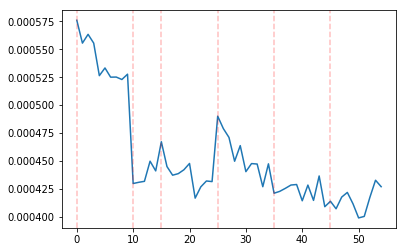

In [52]:
pl.figure()
pl.plot(volume_mean_intensity)
pl.axvline(0, linestyle='--', color='red', alpha=0.25)
ii = -1 # to account for the removed b0 in the first one
for data in datas[:-2]:
    ii += data.shape[3]
    pl.axvline(ii, linestyle='--', color='red', alpha=0.25)
pl.show()

In [54]:
mask_imgs = [nib.load(basename+'{}/mask.nii'.format(num)) for num in scnannum[:-1]]
masks = [img.get_fdata().astype(np.bool) for img in mask_imgs]

In [55]:
volume_mean_inside = []
volume_mean_background = []

Ns = [data.shape[3] for data in datas[:-1]]
Ns[0] -= 1 # remove b0

for i in range(data_cat.shape[3]):
    mask_idx = np.where((i - np.cumsum(Ns)) < 0)[0][0]
    # print(i, mask_idx)
    volume_mean_inside.append(data_cat[...,i][np.logical_not(masks[mask_idx])].mean())
    volume_mean_background.append(data_cat[...,i][masks[mask_idx]].mean())

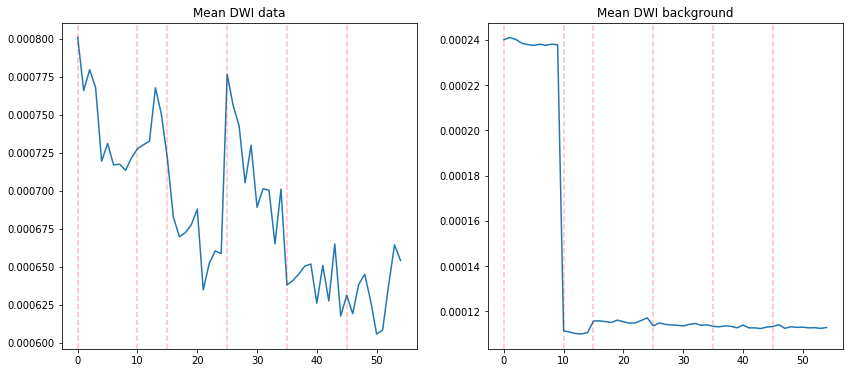

In [60]:
pl.figure(figsize=(14,6))
pl.subplot(1,2,1)
pl.title('Mean DWI data')
pl.plot(np.array(volume_mean_inside), label='data')
pl.axvline(0, linestyle='--', color='red', alpha=0.25)
ii = -1 # to account for the removed b0 in the first one
for data in datas[:-2]:
    ii += data.shape[3]
    pl.axvline(ii, linestyle='--', color='red', alpha=0.25)
pl.subplot(1,2,2)
pl.title('Mean DWI background')
pl.plot(np.array(volume_mean_background), label='background')
pl.axvline(0, linestyle='--', color='red', alpha=0.25)
ii = -1 # to account for the removed b0 in the first one
for data in datas[:-2]:
    ii += data.shape[3]
    pl.axvline(ii, linestyle='--', color='red', alpha=0.25)
pl.show()

In [113]:
baseline_image = b0_first
noisier_image = b0_last

backmask = masks[0]

In [114]:
sigma2 = noisier_image[backmask].mean() / noisier_image[np.logical_not(backmask)].mean()
sigma1 = baseline_image[backmask].mean() / baseline_image[np.logical_not(backmask)].mean()
k2 = sigma2/sigma1
print(k2)

1.0468203457534475


In [121]:
noisier_image[np.logical_not(backmask)].mean()

0.0028109129010140546

In [122]:
baseline_image[np.logical_not(backmask)].mean()

0.003004344094430673

In [115]:
# above 1 mean noisier than just using the less noisy one
predicted_dumb = (k2**2 + 1)/4
w1_dumb = 0.5
w2_dumb = 0.5
print('Predicted from normal averaging {:.3f}'.format(predicted_dumb)) # absolute best would be 1/root(2)

Predicted from normal averaging 0.524


In [116]:
# above 1 mean noisier than just using the less nosiy one
predicted_optimal = 2*(k2/(k2+1))**2
w2_optimal = 1/(k2+1)
w1_optimal = 1 - w2_optimal
print('Predicted from normal averaging {:.3f}'.format(predicted_optimal)) # absolute best would be 1/root(2)

Predicted from normal averaging 0.523


In [117]:
average_dumb = w1_dumb*noisier_image + w2_dumb*baseline_image
average_optimal = w1_optimal*noisier_image + w2_optimal*baseline_image

In [118]:
sigma_dumb = average_dumb[backmask].mean() / average_dumb[np.logical_not(backmask)].mean()
sigma_optimal = average_optimal[backmask].mean() / average_optimal[np.logical_not(backmask)].mean()
print(sigma_dumb/sigma1)
print(sigma_optimal/sigma1)

1.0226314871400173
1.0231668020110392


## averaging different SNR thinkering

In [41]:
K = np.linspace(1, 5, 3333, endpoint=True)

In [42]:
def case1(k):
    return k**2/4 + 0.25

In [43]:
def case2(k):
    return 1+((k-1)/k)**2

In [44]:
def case3(k):
    return 2*(k/(k+1))**2

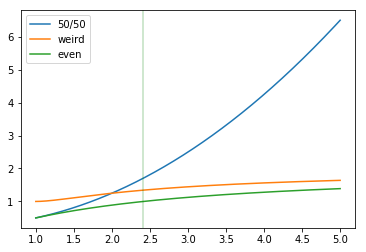

In [45]:
pl.figure()
pl.plot(K, case1(K), label='50/50')
pl.plot(K, case2(K), label='weird')
pl.plot(K, case3(K), label='even')
pl.axvline(K[case3(K)<1].max(), color='green', alpha=0.25) # where it stop reducing the variance
pl.legend()
pl.show()

In [46]:
K[case3(K)<1].max()

2.4141656662665065

In [47]:
1+2**.5

2.414213562373095

In [17]:
def case4(k2, k3):
    w2 = k3/(k2*k3+k2+k3)
    w1 = k2*w2
    w3 = 1-w1-w2
    return w1**2 + w2**2*k2**2 + w3**2*k3**2

In [32]:
K = np.linspace(1, 5, 200, endpoint=True)

In [33]:
grid = np.zeros((len(K), len(K)))
for i2,k2 in enumerate(K):
    for i3,k3 in enumerate(K):
        grid[i2,i3] = case4(k2, k3)

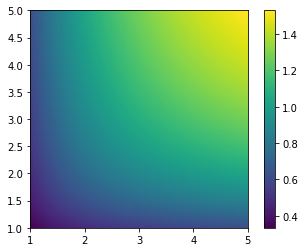

In [34]:
pl.figure()
pl.imshow(grid, origin='lower', extent=(K.min(), K.max(), K.min(), K.max()))
pl.colorbar()
pl.show()